# Feature engenering y selection.

Based on the business table, the VADER sentiment analysis table, we will build our dataset to train models.
We build an original feature, based on calculating the mean of the sum of the category codes, ordering those codes from highest to lowest frequency in the subset of restaurants. It reflects the specialisation with which restaurants present themselves to their customers, how they want to differentiate their offer. Thus, a restaurant with only restaurant as a category will have a value of 0 for this characteristic. In contrast to a restaurant with higher codes, such as Calabrian cuisine, it will go up to a maximum value of 600 for this characteristic.

From the VADER table, coming from the reviews, we will take into account, the stars given by the last user who made a comment, the compound of the average VADER sentiment analysis of the comments since 2016, and the year of the first and the last comment. With the last review we want to include if there can be a contagion effect, with the data of the years, the age and interest of the reviewers for this business, and with the compound the feelings that they are transmitting in their comments in the last 5 years.

We will stay with businesses that have a minimum of 5 comments since 2016, to have a minimum of reviews.

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gc


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import datetime

In [ ]:
from psutil import virtual_memory
print(f'Trabajando con {round(virtual_memory().total / 1e9,2)} gigas de RAM.')

Trabajando con 27.33 gigas de RAM.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/yelp/notebooks')

In [ ]:
def top_correlation (df,metodo='pearson',limit_inf=0.8,limit_sup=1):
    '''
    Devuelve los pares de variables entre unos limites de asoc./correlación como frame,
    junto con su coeficiente, ordenados de mayor a menor.
       
    Args:
     param1: Datafram e a estudiar.
     param2: Metodo de cálculo de la aociación.
     param3: limite inferior del coef.
     param4: limite superior del coef.
     
     
     Returns:
     Pandas dataframe 
    '''
    
    if metodo == 'pearson':
      corr_matrix = df.corr(metodo)
    
    elif metodo == 'spearman':
      candidatos = [col for col in df.columns if col in categorical_vars ]
      for col in candidatos:
        df[col] = pd.factorize(df[col])[0]
      corr_matrix = df.apply(pd.to_numeric, errors = 'ignore').corr(metodo)
    else:
      print('Metodo no soportado')
      return None

    
       
    correlation = (corr_matrix.where(
                np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool_)).
                stack().
                sort_values(ascending = False))
    
    correlation = pd.DataFrame(correlation).reset_index()
    correlation.columns = ["Variable_1", "Variable_2", "Correlacion"]
    correlation = (correlation.reindex (correlation.Correlacion.abs().
                     sort_values (ascending = False).index).
                    reset_index().
                    drop(["index"],axis = 1))
    
           
    return correlation[correlation['Correlacion'].abs().  \
                       between(limit_inf,limit_sup,inclusive = 'right')]

In [ ]:
def get_corr_matrix(dataset = None, 
                    isnumeric = True, 
                    size_figure = [25,20],
                    limit = 0):
    '''
    Genera gráficos representando toda la matriz de correlación.
     Permite aplicar pearson a las variables númericas o spearman a todo el conjunto de variables.
    
    Args:
    param1: Pandas Df de datos.
    param2: Sí True, pearson, False Spearman.
    param3: Tamaño de figura de salida.
    param4: Limite inferior del coeficiente de correlación a mostrar.
    
             
    Returns:
    Sns heatmap.
    
    '''
    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    
    if isnumeric:
        metodo = 'pearson'
    else:
        metodo = 'spearman'
        dataset = dataset.apply(pd.to_numeric, errors='ignore')
        for col in categorical_vars:
          dataset[col] = pd.factorize(dataset[col])[0]
    sns.set(style = "white")
    
    # Computa la matriz de correlación.
    corr = dataset.corr(method=metodo)
    
    # Para poder aplicar limite inferior.
    corr = corr[abs(corr) >= limit].fillna(0)
    
    # autocorrelacion a cero, evita distracciones.
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    
    # Genera mascara para dibujar solo el triangulo inferior en heatmap.
    matrix = np.triu(corr)
    

    # Fija tamaño fuente en funcion del número de columans.
    if len(corr)<40: 
        fontsize = 3 
    else: 
        fontsize = 3;
    
    if metodo == 'pearson':
        f, ax = plt.subplots(figsize=size_figure)
        sns.heatmap(corr,
                    center = 0,                    
                    square = True,
                    linewidths = .25,
                    cmap = "vlag",
                    annot = True, fmt = ".1%", annot_kws = {"fontsize":8},
                    mask = matrix, cbar = True,
                    cbar_kws = {"shrink": .5}) 
    else:
        f, ax = plt.subplots(figsize = size_figure)
        sns.heatmap(corr,
                    center = 0,
                    square = True,
                    cbar = True, 
                    cmap = "vlag",
                    mask = matrix,
                    annot = True, fmt = ".1%", annot_kws = {"fontsize":8},
                    cbar_kws = {"shrink": .5})
        ticks = np.arange(corr.shape[0]) + 0.5
        ax.set_xticks(ticks)
        ax.set_xticklabels(corr.columns, rotation = 90, fontsize = 10)
        ax.set_yticks(ticks)
        ax.set_yticklabels(corr.index, rotation = 360, fontsize = 10)
        ax.set_title('correlation matrix')
 
    plt.tight_layout()
    
    
    return None

# We start from the table of restaurants.
We do without the category_1 column, which is equal to zero in all cases.
Let's add the average of the compound de VADER  


In [ ]:
restaurants = pd.read_parquet(r'../data/restaurants/restaurants_open_definitive.parquet')

In [ ]:
restaurants = restaurants.drop('category_1',axis=1)

In [ ]:
vander_rev = pd.read_parquet(r'../data/restaurants/restaurants_vander.parquet')

In [ ]:
vander_rev.date  = pd.to_datetime(vander_rev.date)

In [ ]:
# Generamos nuestro frame resumen por negocios. Revisiones posteriores a 31-12-2015, con cuenta de revisiones, media de estrellas,
# media de compound ( sentimiento compuesto), y fecha minima y máxima-
vander_sum=vander_rev[vander_rev['date']> pd.Timestamp(2015,12,31)].groupby('business_id').agg({'review_stars':'count','compound':'mean','date':['min','max']}).droplevel(0,axis=1)

In [ ]:
vander_sum.columns = ['rew_count_2016','vander_comp_mean','date_min','date_max']

In [ ]:
vander_sum['date_min']=vander_sum['date_min'].dt.year
vander_sum['date_max']=vander_sum['date_max'].dt.year

In [ ]:
vander_sum.date_max.value_counts(normalize=True)

2021    0.574208
2022    0.300849
2020    0.070879
2019    0.036846
2018    0.010503
2017    0.004104
2016    0.002611
Name: date_max, dtype: float64

In [ ]:
vander_sum.dtypes

rew_count_2016        int64
vander_comp_mean    float64
date_min              int64
date_max              int64
dtype: object

In [ ]:
restaurants = pd.merge(restaurants,vander_sum , on='business_id')

In [ ]:
# Left restaurants with more than 5 reviews since 2015.
restaurants = restaurants[restaurants.rew_count_2016>=5]

In [ ]:
# Generate a frame with the geographic and key business data to build our frame for modelling at the end of the grid.
selected_rest_data=restaurants[['metro_area','business_id','stars','name','address', 'city', 'state', 'postal_code', 'latitude', 'longitude']]

In [ ]:
# Delete review_count from the business table to give the same time scale to the number of reviews, since 2016.
# maximum to the number of reviews, since 2016.

restaurants=restaurants.drop('review_count',axis=1)

## We generate a feature to measure the specialisation of restaurants in their presentation to the customer.

By having the category codes sorted from lowest to highest, from most frequent to least frequent. It is easy for us to generate a summary of how specialised restaurants are presented to customers. So a restaurant that only puts restaurant or food as a category, will present a very low average of the category code values (0.5). As the restaurant presents itself as Amreican, this value will go up, but it will still be low because American or pizza is very common. On the other hand, if it uses infrequent terms in its categories, such as Calabrian, which occupies the 1310th place (it is the least frequent of the categories), this value will go up.

As we will find out later, restaurants with a more general offer receive lower scores than specialised restaurants.


In [ ]:
categories = ['category_2','category_3','category_4', 'category_5',
 'category_6','category_7','category_8','category_9','category_10', 'category_11', 'category_12']

# We need to change our value assigned to category not available to zero so as not to influence
# the average
for column in categories:
  restaurants[column].replace(to_replace = 9999, value = 0, inplace=True)

In [ ]:
# Calculate the specialisation featue of the offer as the average of the values of the category codes.
restaurants['cat_value_mean'] = restaurants[categories].mean(axis=1)

In [ ]:
restaurants['cat_value_mean'].describe()

count    33509.000000
mean        26.130000
std         32.752890
min          0.000000
25%          4.909091
50%         14.454545
75%         32.636364
max        605.727273
Name: cat_value_mean, dtype: float64

In [ ]:
restaurants[['stars','cat_value_mean']].corr()

,stars,cat_value_mean
stars,1.000000,0.240044
cat_value_mean,0.240044,1.000000


## Timetable transformation.
We transform the timetables, by opening hours on weekends and opening hours on working days to make it easier for the models to calculate. 

In [ ]:
restaurants['weekend_hours'] = restaurants[['Saturday_work_hours','Saturday_work_hours']].sum(axis=1)

In [ ]:
restaurants['lab_day_hours'] = restaurants[['Friday_work_hours', 'Monday_work_hours', 'Thursday_work_hours', 'Tuesday_work_hours',
 'Wednesday_work_hours']].sum(axis = 1)

## We define columns to eliminate.
First of all we want to make a generic model for the 11 metropolitan areas. So we dispense with them, with the business data, name, address, city, state, location. And the columns that we have summarised, and the stars after 2015 that come from VADER.

In [ ]:
columns_to_drop = ['metro_area','business_id','name','address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'is_open','category_2','category_3','category_4','category_5',
 'category_6', 'category_7', 'category_8', 'category_9', 'category_10', 'category_11', 'category_12','Friday_work_hours',
 'Monday_work_hours', 'Saturday_work_hours', 'Sunday_work_hours', 'Thursday_work_hours', 'Tuesday_work_hours',
 'Wednesday_work_hours']

In [ ]:
restaurants = restaurants.drop(columns_to_drop,axis = 1)

In [ ]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33509 entries, 0 to 34847
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stars                       33509 non-null  float64
 1   Alcohol                     33509 non-null  object 
 2   BikeParking                 33509 non-null  bool   
 3   BusinessAcceptsBitcoin      33509 non-null  bool   
 4   BusinessAcceptsCreditCards  33509 non-null  bool   
 5   BusinessParking             33509 non-null  bool   
 6   ByAppointmentOnly           33509 non-null  bool   
 7   Caters                      33509 non-null  bool   
 8   DogsAllowed                 33509 non-null  bool   
 9   DriveThru                   33509 non-null  bool   
 10  GoodForKids                 33509 non-null  bool   
 11  HappyHour                   33509 non-null  bool   
 12  HasTV                       33509 non-null  bool   
 13  Music                       335

In [ ]:
#Revised object columns
restaurants.select_dtypes(include = 'object').describe().T

,count,unique,top,freq
Alcohol,33509,4,none,13177
NoiseLevel,33509,6,average,15869
RestaurantsAttire,33509,5,casual,23025
WiFi,33509,4,free,13879


In [ ]:
# Transform them into a category, adding the price level
categorical_vars = restaurants.select_dtypes(include = 'object').columns.tolist()
categorical_vars.append( 'RestaurantsPriceRange2' )
restaurants[categorical_vars] = restaurants[categorical_vars].astype('category')

In [ ]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33509 entries, 0 to 34847
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   stars                       33509 non-null  float64 
 1   Alcohol                     33509 non-null  category
 2   BikeParking                 33509 non-null  bool    
 3   BusinessAcceptsBitcoin      33509 non-null  bool    
 4   BusinessAcceptsCreditCards  33509 non-null  bool    
 5   BusinessParking             33509 non-null  bool    
 6   ByAppointmentOnly           33509 non-null  bool    
 7   Caters                      33509 non-null  bool    
 8   DogsAllowed                 33509 non-null  bool    
 9   DriveThru                   33509 non-null  bool    
 10  GoodForKids                 33509 non-null  bool    
 11  HappyHour                   33509 non-null  bool    
 12  HasTV                       33509 non-null  bool    
 13  Music           

# Review of correlations.
We are not surprised by the high correlation of the scores with the mean of the VADER compound. It means that the sentiment expressed in the opinions is consistent with the score they give.

The specialisation of the offer, our feature based on the category codes, has one of the highest positive correlations within the set of characteristics. Wheelchair access seems to be valued.

It seems that availability, opening hours, whether they serve in the car or serve at home, have a negative impact on the level of ratings. 

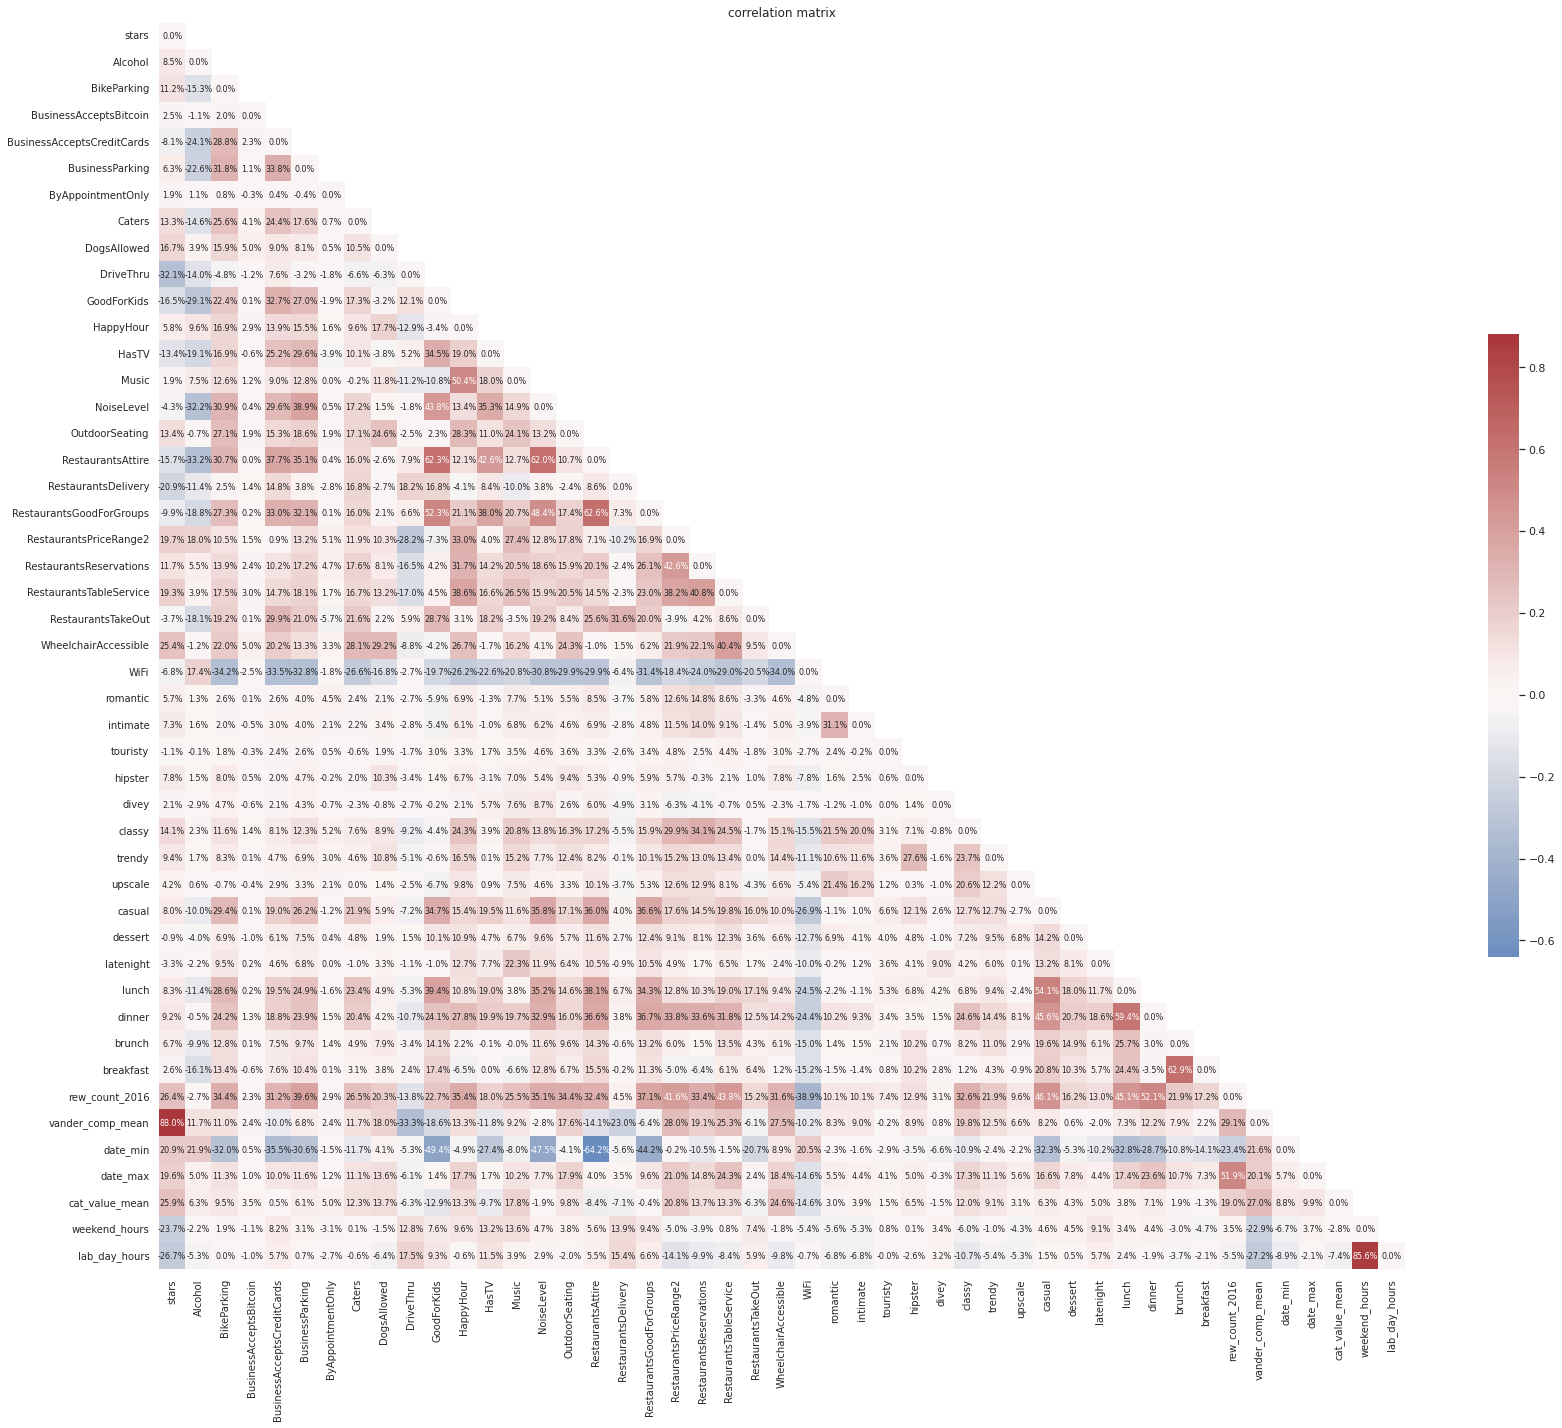

In [ ]:
get_corr_matrix(restaurants,isnumeric=False)

In [ ]:
top_correlation (restaurants,metodo = 'spearman', limit_inf = 0.40, limit_sup = 0.99)

,Variable_1,Variable_2,Correlacion
0,stars,vander_comp_mean,0.880399
1,weekend_hours,lab_day_hours,0.855545
2,RestaurantsAttire,date_min,-0.641553
3,brunch,breakfast,0.629238
4,RestaurantsAttire,RestaurantsGoodForGroups,0.625917
5,GoodForKids,RestaurantsAttire,0.622745
6,NoiseLevel,RestaurantsAttire,0.620386
7,lunch,dinner,0.593688
8,casual,lunch,0.540959
9,GoodForKids,RestaurantsGoodForGroups,0.523431


### Target definition and choice of predictors.

Our model will try to predict the stars that users will give you, based on your service offer and the sentiment analysis of your customers' ratings. 
To do this, we will scale the reviews, being negative those businesses that present 2 or less stars of average rating, neutral more than 2 and 3.5 stars including 3.5, and positive more than 3.5 stars on average.


In [ ]:
def categorize(x):
    if x <= 2:
        return 'negativo'
    elif x <= 3.5:
        return 'neutro'
    else:
        return 'positivo'


In [ ]:
# Transform the target into the categories proposed.
restaurants['stars'] = restaurants['stars'].apply(categorize)


In [ ]:
restaurants['stars'].value_counts()

positivo    15927
neutro      14265
negativo     3317
Name: stars, dtype: int64

In [ ]:
# Transform stars from the frame we will merge to the end of the notebook
selected_rest_data['stars'] = restaurants['stars'].tolist()

In [ ]:
# Transform into categorical.
restaurants['stars'] = restaurants['stars'].astype('category')
selected_rest_data['stars'] = selected_rest_data['stars'].astype('category')

In [ ]:
# Transform bool dtypes to int.
restaurants_bools = restaurants.select_dtypes(include = 'bool').columns.tolist()
restaurants[restaurants_bools] = restaurants[restaurants_bools] * 1

In [ ]:
restaurants

,stars,Alcohol,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,BusinessParking,ByAppointmentOnly,Caters,DogsAllowed,DriveThru,...,dinner,brunch,breakfast,rew_count_2016,vander_comp_mean,date_min,date_max,cat_value_mean,weekend_hours,lab_day_hours
0,positivo,0,1,0,0,1,0,1,0,0,...,0,0,0,45,0.671747,2016,2021,26.090909,28,66
2,negativo,0,0,0,1,1,0,0,0,1,...,0,0,0,9,0.355822,2016,2021,7.636364,22,50
3,positivo,0,0,0,0,1,0,0,0,0,...,0,0,0,11,0.743791,2018,2022,22.727273,10,15
4,neutro,0,0,0,1,1,0,0,0,0,...,0,0,0,24,0.101208,2016,2021,10.727273,32,80
5,positivo,1,0,0,1,1,0,0,0,0,...,1,0,0,250,0.803010,2017,2022,12.818182,18,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34843,positivo,1,1,0,1,1,0,0,0,1,...,1,0,0,740,0.798336,2016,2022,22.272727,24,46
34844,neutro,2,1,0,1,1,0,1,0,0,...,0,0,0,7,0.370843,2016,2020,8.545455,0,0
34845,positivo,0,1,0,1,1,0,0,0,0,...,0,0,0,23,0.422991,2016,2021,12.272727,0,17
34846,positivo,0,1,0,1,1,0,1,0,0,...,1,0,0,35,0.869034,2017,2021,2.454545,30,48


In [ ]:
X = restaurants.drop(['stars'],axis=1)
y = restaurants['stars']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, stratify = y)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26807 entries, 16890 to 15835
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Alcohol                     26807 non-null  int64  
 1   BikeParking                 26807 non-null  int64  
 2   BusinessAcceptsBitcoin      26807 non-null  int64  
 3   BusinessAcceptsCreditCards  26807 non-null  int64  
 4   BusinessParking             26807 non-null  int64  
 5   ByAppointmentOnly           26807 non-null  int64  
 6   Caters                      26807 non-null  int64  
 7   DogsAllowed                 26807 non-null  int64  
 8   DriveThru                   26807 non-null  int64  
 9   GoodForKids                 26807 non-null  int64  
 10  HappyHour                   26807 non-null  int64  
 11  HasTV                       26807 non-null  int64  
 12  Music                       26807 non-null  int64  
 13  NoiseLevel                 

In [ ]:
!pip install category_encoders
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 KB 1.9 MB/s eta 0:00:00


In [ ]:


list_columns_cat = [col for col in X_train.columns if col in categorical_vars ]
list_other = list(set(X_train.columns)-set(list_columns_cat))
one = ce.OneHotEncoder(cols=list_columns_cat)
model = one.fit(X_train, y_train)

In [ ]:
X_train_t = model.transform(X_train, y_train)
X_test_t = model.transform(X_test, y_test)
len(list(X_train_t.columns))

65

In [ ]:
X_train_t.columns

Index(['Alcohol_1', 'Alcohol_2', 'Alcohol_3', 'Alcohol_4', 'BikeParking',
       'BusinessAcceptsBitcoin', 'BusinessAcceptsCreditCards',
       'BusinessParking', 'ByAppointmentOnly', 'Caters', 'DogsAllowed',
       'DriveThru', 'GoodForKids', 'HappyHour', 'HasTV', 'Music',
       'NoiseLevel_1', 'NoiseLevel_2', 'NoiseLevel_3', 'NoiseLevel_4',
       'NoiseLevel_5', 'NoiseLevel_6', 'OutdoorSeating', 'RestaurantsAttire_1',
       'RestaurantsAttire_2', 'RestaurantsAttire_3', 'RestaurantsAttire_4',
       'RestaurantsAttire_5', 'RestaurantsDelivery',
       'RestaurantsGoodForGroups', 'RestaurantsPriceRange2_1',
       'RestaurantsPriceRange2_2', 'RestaurantsPriceRange2_3',
       'RestaurantsPriceRange2_4', 'RestaurantsPriceRange2_5',
       'RestaurantsReservations', 'RestaurantsTableService',
       'RestaurantsTakeOut', 'WheelchairAccessible', 'WiFi_1', 'WiFi_2',
       'WiFi_3', 'WiFi_4', 'romantic', 'intimate', 'touristy', 'hipster',
       'divey', 'classy', 'trendy', 'upscale', '

In [ ]:
# Estandarizamos todas las variables, media 0, desviacion estandar 1.

scaler = StandardScaler()
model_scaled = scaler.fit(X_train_t)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_t), columns = X_train_t.columns, index = X_train_t.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_t), columns = X_test_t.columns, index = X_test.index)

## Selection of characteristics.
From the different methods of variable selection, we can see that we will not need a reduced number of variables to make our classification.
We are going to make a selection based on the set of variables selected by logistic regression, random-forrest.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty = "l2", solver = 'newton-cg'), max_features = 40)
embeded_lr_selector.fit(X_train_scaled, y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train_scaled.loc[:, embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

12 selected features


In [ ]:
embeded_lr_feature

['Alcohol_2',
 'BikeParking',
 'Caters',
 'DriveThru',
 'romantic',
 'intimate',
 'hipster',
 'upscale',
 'rew_count_2016',
 'vander_comp_mean',
 'date_max',
 'cat_value_mean']

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators = 25), max_features = 40)
embeded_rf_selector.fit(X_train_scaled , y_train)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train_scaled.loc[:, embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

8 selected features


In [ ]:
embeded_rf_feature

['DriveThru',
 'rew_count_2016',
 'vander_comp_mean',
 'date_min',
 'date_max',
 'cat_value_mean',
 'weekend_hours',
 'lab_day_hours']

In [ ]:
!pip install Boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 1.6 MB/s eta 0:00:00


In [ ]:
from boruta import BorutaPy
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, max_depth=10) # cambiar los hiperparametros

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators=15, max_iter=40,verbose=2, random_state=1)

# find all relevant features 
feat_selector.fit(X_train_t.values, y_train.values) # Importante poner el .values al dataframe, sino dará error

# check selected features - first 15 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

Iteration: 	1 / 40
Confirmed: 	0
Tentative: 	65
Rejected: 	0
Iteration: 	2 / 40
Confirmed: 	0
Tentative: 	65
Rejected: 	0
Iteration: 	3 / 40
Confirmed: 	0
Tentative: 	65
Rejected: 	0
Iteration: 	4 / 40
Confirmed: 	0
Tentative: 	65
Rejected: 	0
Iteration: 	5 / 40
Confirmed: 	0
Tentative: 	65
Rejected: 	0
Iteration: 	6 / 40
Confirmed: 	0
Tentative: 	65
Rejected: 	0
Iteration: 	7 / 40
Confirmed: 	0
Tentative: 	65
Rejected: 	0
Iteration: 	8 / 40
Confirmed: 	9
Tentative: 	10
Rejected: 	46
Iteration: 	9 / 40
Confirmed: 	9
Tentative: 	10
Rejected: 	46
Iteration: 	10 / 40
Confirmed: 	9
Tentative: 	10
Rejected: 	46
Iteration: 	11 / 40
Confirmed: 	9
Tentative: 	10
Rejected: 	46
Iteration: 	12 / 40
Confirmed: 	9
Tentative: 	6
Rejected: 	50
Iteration: 	13 / 40
Confirmed: 	9
Tentative: 	6
Rejected: 	50
Iteration: 	14 / 40
Confirmed: 	9
Tentative: 	6
Rejected: 	50
Iteration: 	15 / 40
Confirmed: 	9
Tentative: 	6
Rejected: 	50
Iteration: 	16 / 40
Confirmed: 	9
Tentative: 	5
Rejected: 	51
Iteration: 	1

array([31,  1, 22, 14, 15, 54, 29, 30, 50,  8, 10,  1, 13, 22,  6, 25, 18,
       33, 32, 37, 37, 56, 21,  3,  8, 49, 55, 51,  1, 17, 12,  5,  1, 43,
       51, 24,  7, 27,  2, 26, 28, 33, 47, 46, 45, 48, 35, 44, 19, 35, 53,
       10, 42, 40, 16, 20, 40, 39,  1,  1,  1,  3,  1,  1,  1])

In [ ]:
embeded_bor_support = feat_selector.support_
embeded_bor_feature = X_train_t.loc[:, embeded_bor_support].columns.tolist()
print(str(len(embeded_bor_feature)), 'selected features')

10 selected features


In [ ]:
embeded_bor_feature

['Alcohol_2',
 'DriveThru',
 'RestaurantsDelivery',
 'RestaurantsPriceRange2_3',
 'rew_count_2016',
 'vander_comp_mean',
 'date_min',
 'cat_value_mean',
 'weekend_hours',
 'lab_day_hours']

## Variable selection.
Considering the variables selected with SelectModel and Boruta, we are going to stay for the models with ['Alcohol_2',
 'DriveThru',
 'RestaurantsDelivery',
 'RestaurantsPriceRange2',
 'rew_count_2016',
 'vander_comp_mean',
 'date_min',
 'cat_value_mean',
 'weekend_hours',
 'lab_day_hours']. 
 
 These will be the characteristics with which we will build our star prediction model.

In [ ]:
X.shape

(33509, 47)

In [ ]:
selected_rest_data.shape

(33509, 10)

In [ ]:
X_selected = X[['Alcohol', 'DriveThru', 'RestaurantsDelivery', 'RestaurantsPriceRange2','rew_count_2016','vander_comp_mean','date_min',
 'cat_value_mean', 'weekend_hours', 'lab_day_hours']]

In [ ]:
restaurants_data_models=pd.concat([selected_rest_data,X_selected ],axis=1)

In [ ]:
restaurants_data_models.columns

Index(['metro_area', 'business_id', 'stars', 'name', 'address', 'city',
       'state', 'postal_code', 'latitude', 'longitude', 'Alcohol', 'DriveThru',
       'RestaurantsDelivery', 'RestaurantsPriceRange2', 'rew_count_2016',
       'vander_comp_mean', 'date_min', 'cat_value_mean', 'weekend_hours',
       'lab_day_hours'],
      dtype='object')

In [ ]:
restaurants_data_models

,metro_area,business_id,stars,name,address,city,state,postal_code,latitude,longitude,Alcohol,DriveThru,RestaurantsDelivery,RestaurantsPriceRange2,rew_count_2016,vander_comp_mean,date_min,cat_value_mean,weekend_hours,lab_day_hours
0,Philadelphia,MTSW4McQd7CbVtyjqoe9mw,positivo,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,0,0,0,0,45,0.671747,2016,26.090909,28,66
2,Nashville,bBDDEgkFA1Otx9Lfe7BZUQ,negativo,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,0,1,1,0,9,0.355822,2016,7.636364,22,50
3,Tampa,eEOYSgkmpB90uNA7lDOMRA,positivo,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,0,0,0,1,11,0.743791,2018,22.727273,10,15
4,Indianapolis,il_Ro8jwPlHresjw9EGmBg,neutro,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,0,0,1,0,24,0.101208,2016,10.727273,32,80
5,Philadelphia,MUTTqe8uqyMdBl186RmNeA,positivo,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,1,0,1,2,250,0.803010,2017,12.818182,18,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34843,Boise,w_4xUt-1AyY2ZwKtnjW0Xg,positivo,Bittercreek Alehouse,246 N 8th St,Boise,ID,83702,43.616590,-116.202383,1,1,0,2,740,0.798336,2016,22.272727,24,46
34844,Philadelphia,l9eLGG9ZKpLJzboZq-9LRQ,neutro,Wawa,19 N Bishop Ave,Clifton Heights,PA,19018,39.925656,-75.310344,2,0,1,0,7,0.370843,2016,8.545455,0,0
34845,Boise,cM6V90ExQD6KMSU3rRB5ZA,positivo,Dutch Bros Coffee,1181 N Milwaukee St,Boise,ID,83704,43.615401,-116.284689,0,0,0,0,23,0.422991,2016,12.272727,0,17
34846,Philadelphia,WnT9NIzQgLlILjPT0kEcsQ,positivo,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,PA,19147,39.935982,-75.158665,0,0,1,2,35,0.869034,2017,2.454545,30,48


In [ ]:
restaurants_data_models.to_parquet("../data/restaurants/restaurants_data_models.parquet",
              compression='gzip')

In [ ]:
restaurants_data_models.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,33509.0,36.932035,6.011475,27.564457,32.183003,39.456435,39.959169,53.649743
longitude,33509.0,-87.829183,13.713526,-120.083748,-90.224017,-86.027664,-75.379921,-74.680250
Alcohol,33509.0,1.074249,1.033105,0.000000,0.000000,1.000000,2.000000,3.000000
DriveThru,33509.0,0.095049,0.293287,0.000000,0.000000,0.000000,0.000000,1.000000
RestaurantsDelivery,33509.0,0.641589,0.479541,0.000000,0.000000,1.000000,1.000000,1.000000
RestaurantsPriceRange2,33509.0,1.092035,0.956218,0.000000,0.000000,1.000000,2.000000,4.000000
rew_count_2016,33509.0,78.623504,153.634748,5.000000,14.000000,33.000000,84.000000,5939.000000
vander_comp_mean,33509.0,0.530695,0.313018,-0.784640,0.370547,0.624169,0.764386,0.993762
date_min,33509.0,2016.794861,1.482659,2015.000000,2016.000000,2016.000000,2017.000000,2022.000000
cat_value_mean,33509.0,26.130000,32.752890,0.000000,4.909091,14.454545,32.636364,605.727273


In [ ]:
selected = ['Alcohol', 'DriveThru', 'RestaurantsDelivery', 'RestaurantsPriceRange2','rew_count_2016','vander_comp_mean','date_min',
 'cat_value_mean', 'weekend_hours', 'lab_day_hours']

In [ ]:
X_train_selected = X_train[selected]
X_test_selected = X_test[selected]

In [ ]:
list_columns_cat = [col for col in X_train_selected.columns if col in categorical_vars ]
list_other = list(set(X_train_selected.columns) - set(list_columns_cat))
one = ce.OneHotEncoder(cols=list_columns_cat)
model = one.fit(X_train_selected, y_train)

In [ ]:
X_train_selected_t = model.transform(X_train_selected, y_train)
X_test_selected_t = model.transform(X_test_selected, y_test)
len(list(X_train_selected_t.columns))

17

In [ ]:
X_train_selected_t.columns

Index(['Alcohol_1', 'Alcohol_2', 'Alcohol_3', 'Alcohol_4', 'DriveThru',
       'RestaurantsDelivery', 'RestaurantsPriceRange2_1',
       'RestaurantsPriceRange2_2', 'RestaurantsPriceRange2_3',
       'RestaurantsPriceRange2_4', 'RestaurantsPriceRange2_5',
       'rew_count_2016', 'vander_comp_mean', 'date_min', 'cat_value_mean',
       'weekend_hours', 'lab_day_hours'],
      dtype='object')

In [ ]:

RF = RandomForestClassifier(n_estimators = 50, max_features= 'sqrt', max_depth = 50, criterion='entropy')

# the model is trained with the training dataset
RF.fit(X_train_selected_t, y_train)



RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt',
                       n_estimators=50)

In [ ]:
RF.fit(X_train_selected_t, y_train)


RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt',
                       n_estimators=50)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# predicts the class of test
predictions = RF.predict(X_test_selected_t )

# Evaluate predictions
print(RF.score(X_test_selected_t, y_test) * 100)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, RF.predict(X_test_selected_t)))

82.43807818561623
[[ 490  171    2]
 [ 132 2262  459]
 [   0  413 2773]]
              precision    recall  f1-score   support

    negativo       0.79      0.74      0.76       663
      neutro       0.79      0.79      0.79      2853
    positivo       0.86      0.87      0.86      3186

    accuracy                           0.82      6702
   macro avg       0.81      0.80      0.81      6702
weighted avg       0.82      0.82      0.82      6702



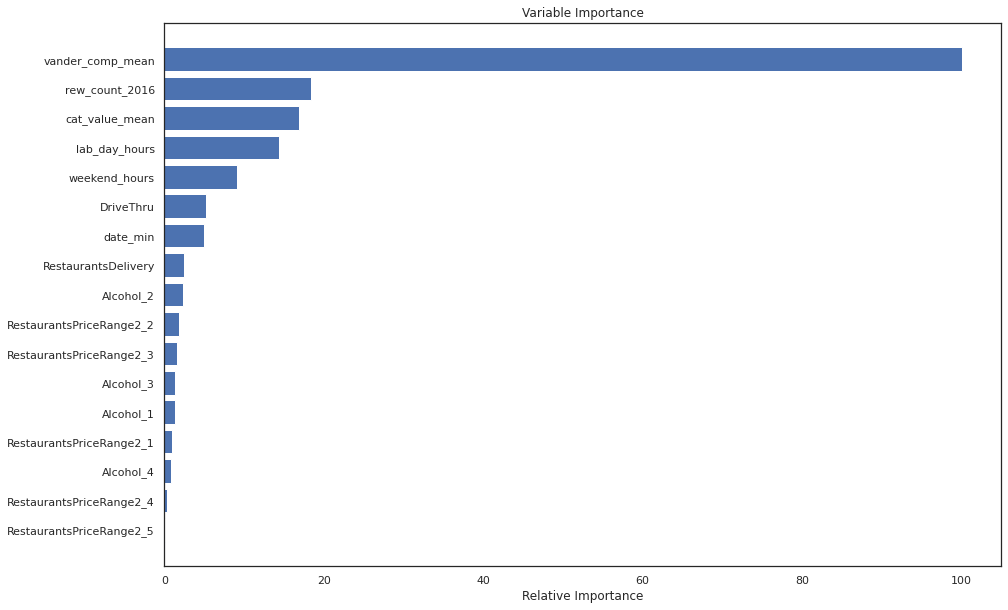

In [ ]:
feature_importance = RF.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(15, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_selected_t.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()